In [1]:
from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.exceptions import ConvergenceWarning
simplefilter('ignore', category=ConvergenceWarning)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from tqdm.notebook import tqdm

Using TensorFlow backend.


In [2]:
f = np.genfromtxt('data_banknote_authentication.txt', delimiter=',')
p = pd.read_csv('data_banknote_authentication.txt', names=['variance', 'skeweness', 'curtosis', 'entropy', 'class'])
labels = p.iloc[:,-1]
features = p.iloc[:, :-1]

features.shape, labels.shape

((1372, 4), (1372,))

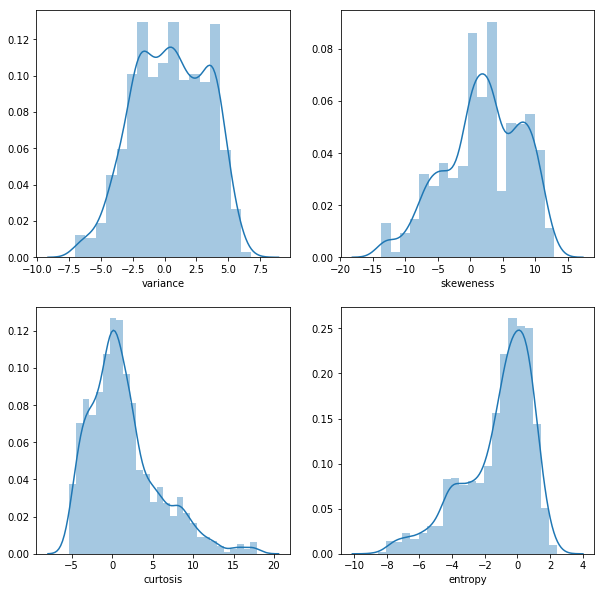

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(p['variance'], ax=ax[0][0])
sns.distplot(p['skeweness'], ax=ax[0][1])
sns.distplot(p['curtosis'], ax=ax[1][0])
sns.distplot(p['entropy'], ax=ax[1][1])
plt.show()

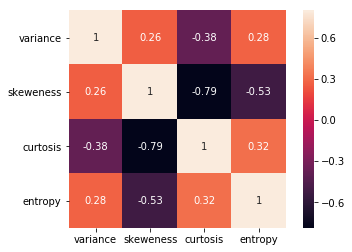

In [4]:
correlation = features.corr()
sns.heatmap(correlation, vmax=.8, square=True, annot=True)

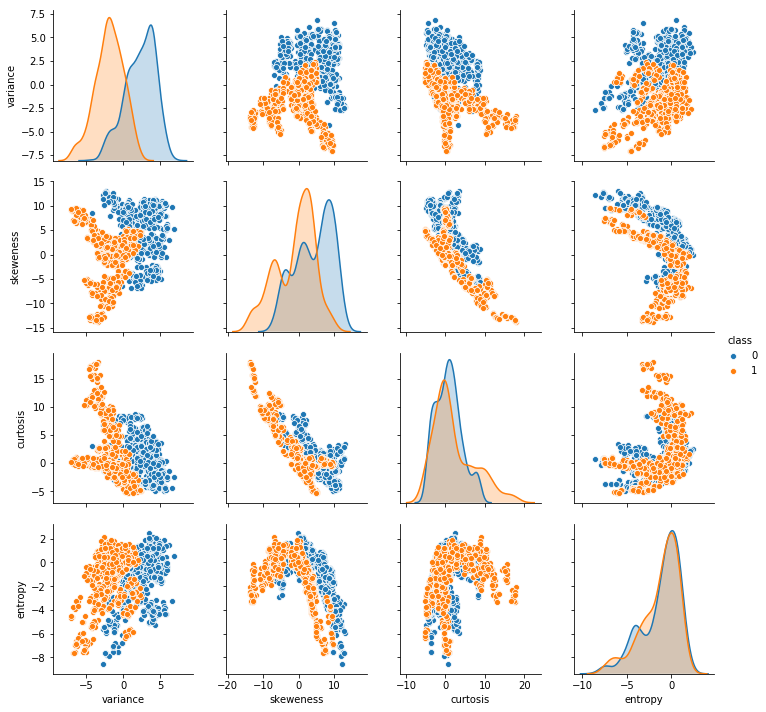

In [5]:
sns.pairplot(p, hue='class', x_vars=['variance', 'skeweness', 'curtosis', 'entropy'], y_vars=['variance', 'skeweness', 'curtosis', 'entropy'])

In [6]:
models = {
    'NB': GaussianNB(),
    'LR': LogisticRegression(solver='saga'),
    'SGD': SGDClassifier(),
    'kNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(max_depth=10, random_state=42),
    'RF': RandomForestClassifier(n_estimators=25, random_state=42),
    'linearSVC': SVC(kernel='linear', random_state=42),
    'rbfSVC': SVC(kernel='rbf', random_state=42),
    'MLP': MLPClassifier(random_state=42, max_iter=1000),
}

In [7]:
feature_sets = {}
for i in range(2, len(features.columns) + 1):
    comb = itertools.combinations(features.columns, i)
    for x in comb:
        key = '/'.join(x)
        value = list(x)
        feature_sets.update({key: value})

In [8]:
KF = KFold(n_splits=5)

In [9]:
def run_models_on_all_feature_sets(models, data, labels, all_features, kf):
    all_scores = pd.DataFrame(columns=list(models.keys()), index=all_features.keys())
    for i, (name, model) in tqdm(enumerate(models.items())):
        for feature_set_name, feature_set in all_features.items():
            scores = []
            for train_index, test_index in kf.split(data):
                X_train, X_test = data[feature_set].iloc[train_index], data[feature_set].iloc[test_index]
                y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
                model.fit(X_train, y_train)
                scores.append(model.score(X_test, y_test))
            all_scores.loc[feature_set_name, name] = np.mean(scores)
    return all_scores

In [10]:
all_scores = run_models_on_all_feature_sets(models, features, labels, feature_sets, KF)

|          | 0/? [00:00<?, ?it/s]

In [11]:
def format_scores(scores, ax):
    def highlight(s):
        is_max = s == max(s[0:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=ax)
    return scores.format('{:.2%}')

ipd.display(ipd.Markdown('### Best Feature Set for each Model Type'))
ipd.display(format_scores(all_scores, 0))
ipd.display(ipd.Markdown('### Best Model Type for each Feature Set'))
ipd.display(format_scores(all_scores, 1))

### Best Feature Set for each Model Type

,NB,LR,SGD,kNN,DT,RF,linearSVC,rbfSVC,MLP
variance/skeweness,81.85%,83.38%,76.45%,91.11%,90.52%,91.62%,83.45%,88.85%,90.38%
variance/curtosis,77.91%,81.05%,72.80%,85.93%,84.69%,86.22%,81.34%,86.08%,85.79%
variance/entropy,78.93%,81.85%,83.66%,86.44%,83.67%,85.49%,83.01%,82.72%,85.27%
skeweness/curtosis,54.49%,66.10%,62.82%,85.49%,83.37%,86.15%,68.66%,72.52%,81.48%
skeweness/entropy,51.00%,60.18%,48.37%,83.60%,83.23%,83.89%,60.04%,70.55%,81.78%
curtosis/entropy,48.52%,26.09%,37.51%,59.76%,59.10%,59.54%,14.31%,39.05%,49.18%
variance/skeweness/curtosis,79.37%,98.32%,98.11%,98.98%,97.74%,98.47%,98.54%,98.40%,99.85%
variance/skeweness/entropy,81.34%,83.09%,79.01%,96.72%,94.02%,95.12%,83.23%,93.00%,96.28%
variance/curtosis/entropy,77.98%,87.46%,78.35%,96.87%,94.53%,95.70%,87.90%,96.87%,97.30%
skeweness/curtosis/entropy,55.00%,73.53%,61.72%,94.39%,91.18%,92.64%,77.48%,80.82%,93.07%


### Best Model Type for each Feature Set

,NB,LR,SGD,kNN,DT,RF,linearSVC,rbfSVC,MLP
variance/skeweness,81.85%,83.38%,76.45%,91.11%,90.52%,91.62%,83.45%,88.85%,90.38%
variance/curtosis,77.91%,81.05%,72.80%,85.93%,84.69%,86.22%,81.34%,86.08%,85.79%
variance/entropy,78.93%,81.85%,83.66%,86.44%,83.67%,85.49%,83.01%,82.72%,85.27%
skeweness/curtosis,54.49%,66.10%,62.82%,85.49%,83.37%,86.15%,68.66%,72.52%,81.48%
skeweness/entropy,51.00%,60.18%,48.37%,83.60%,83.23%,83.89%,60.04%,70.55%,81.78%
curtosis/entropy,48.52%,26.09%,37.51%,59.76%,59.10%,59.54%,14.31%,39.05%,49.18%
variance/skeweness/curtosis,79.37%,98.32%,98.11%,98.98%,97.74%,98.47%,98.54%,98.40%,99.85%
variance/skeweness/entropy,81.34%,83.09%,79.01%,96.72%,94.02%,95.12%,83.23%,93.00%,96.28%
variance/curtosis/entropy,77.98%,87.46%,78.35%,96.87%,94.53%,95.70%,87.90%,96.87%,97.30%
skeweness/curtosis/entropy,55.00%,73.53%,61.72%,94.39%,91.18%,92.64%,77.48%,80.82%,93.07%


In [12]:
best = {
    'NB': ['variance', 'skeweness'],
    'LR': ['variance', 'skeweness', 'curtosis', 'entropy'],
    'SGD': ['variance', 'skeweness', 'curtosis', 'entropy'],
    'kNN': ['variance', 'skeweness', 'curtosis', 'entropy'],
    'DT': ['variance', 'skeweness', 'curtosis', 'entropy'],
    'RF': ['variance', 'skeweness', 'curtosis'],
    'linearSVC': ['variance', 'skeweness', 'curtosis', 'entropy'],
    'rbfSVC': ['variance', 'skeweness', 'curtosis', 'entropy'],
    'MLP': ['variance', 'skeweness', 'curtosis', 'entropy'],
}

worst = ['curtosis', 'entropy']

def run_best_models(models, data, labels, kf):
    df = pd.DataFrame(columns=['name', 'score', 'std'])
    for i, (name, model) in enumerate(models.items()):
        scores = []
        for train_index, test_index in kf.split(data):
            X_train, X_test = data[best[name]].iloc[train_index], data[best[name]].iloc[test_index]
            y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(model.score(X_test, y_test))
        df.loc[i] = name, np.mean(scores), np.std(scores)
    return df

def run_worst_models(models, data, labels, kf):
    df = pd.DataFrame(columns=['name', 'score', 'std'])
    for i, (name, model) in enumerate(models.items()):
        scores = []
        for train_index, test_index in kf.split(data):
            X_train, X_test = data[worst].iloc[train_index], data[worst].iloc[test_index]
            y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(model.score(X_test, y_test))
        df.loc[i] = name, np.mean(scores), np.std(scores)
    return df

In [13]:
best_results = run_best_models(models, features, labels, KF)
worst_results = run_worst_models(models, features, labels, KF)

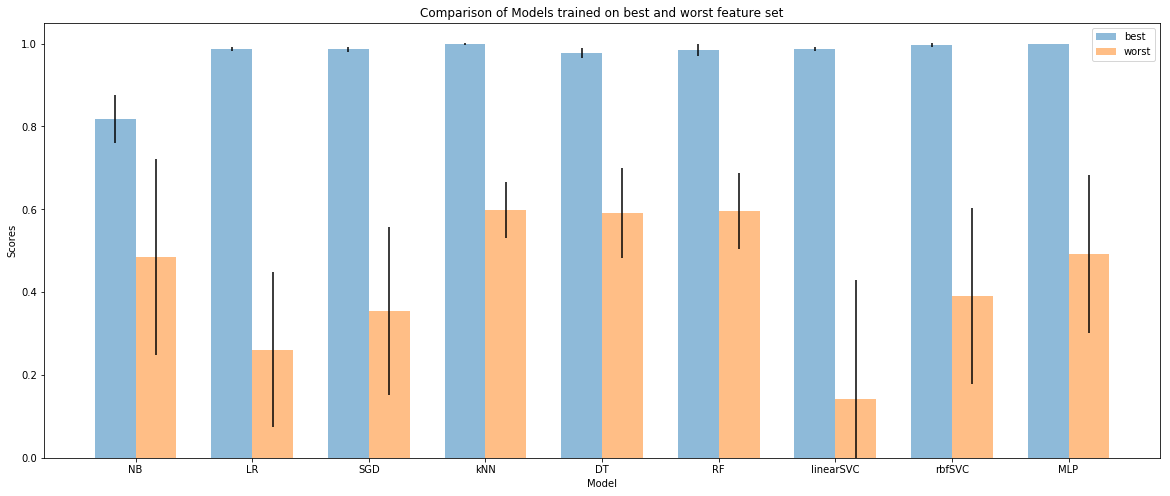

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))
ind = np.arange(len(models.keys()))
width = 0.35
r1 = ax.bar(ind - width/2, best_results['score'], width, yerr=best_results['std'], alpha=0.5, label='best')
r2 = ax.bar(ind + width/2, worst_results['score'], width, yerr=worst_results['std'], alpha=0.5, label='worst')
ax.set_xticks(ind)
ax.set_xticklabels(best_results['name'])
ax.set_ylim(0, 1.05)
ax.set_title("Comparison of Models trained on best and worst feature set")
ax.set_ylabel("Scores")
ax.set_xlabel("Model")
ax.legend()
plt.show()

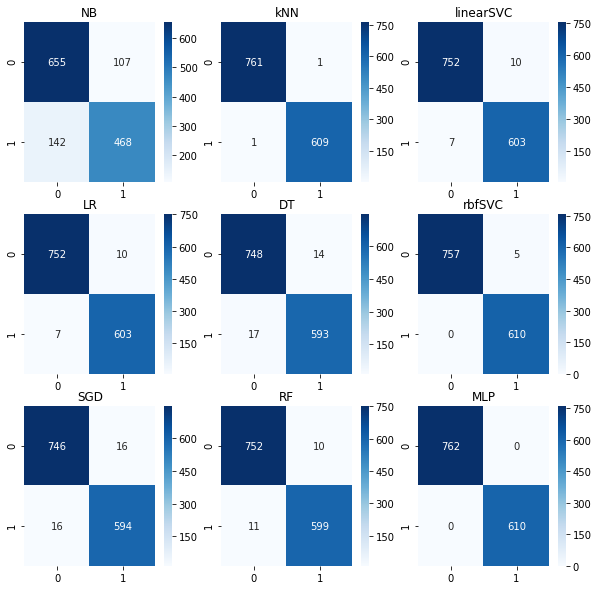

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, (name, model) in enumerate(models.items()):
    y_pred = cross_val_predict(model, features[best[name]], labels, cv=KF)
    conf = confusion_matrix(y_true=labels, y_pred=y_pred)
    sns.heatmap(conf, annot=True, ax=ax[i%3][i//3], cmap=plt.cm.Blues, fmt='d')
    ax[i%3][i//3].set_title(name)

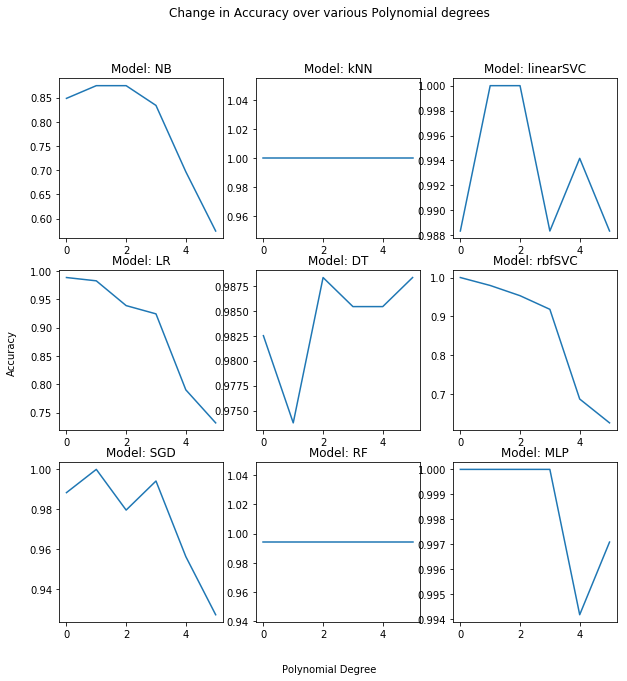

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, (name, model) in enumerate(models.items()):
    scores = []
    for j in range(1, 7):
        poly = PolynomialFeatures(degree=j, include_bias=False)
        x = poly.fit_transform(features[best[name]])
        X_train, X_test, y_train, y_test = train_test_split(x, labels, random_state=42)
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
    ax[i%3][i//3].plot(scores)
    ax[i%3][i//3].set_title("Model: {}".format(name))
    
    
fig.text(0.5, 0.06, "Polynomial Degree", ha='center', va='center')
fig.text(0.06, 0.5, "Accuracy", ha='center', va='center', rotation='vertical')
fig.suptitle("Change in Accuracy over various Polynomial degrees")
plt.show()

In [17]:
model = Sequential()
model.add(Dense(units=8, input_dim=4, activation='relu')) 
model.add(Dense(units=8, activation='relu')) 
model.add(Dense(units=1, activation='sigmoid'))

sgd = SGD(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

h = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=0)
results = model.evaluate(X_test, y_test, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [18]:
print("Loss = %0.4f Accuracy = %0.2f%%" % (results[0], results[1] * 100))

Loss = 0.0268 Accuracy = 100.00%
